In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
iso_fn = "average.iso_adjusted.pdb"
full_fn = "average.full_adjusted.gro"
out_fn = "delta.dat"

In [3]:
iso_P = [];
iso_C4 = [];
full_P = [];
full_C4 = [];

In [4]:
def get_coords(filename, P_list, C4_list):
    with open(filename, 'r') as fin:
        for line in fin:
            entries = line.strip().split();
            resid = int(entries[4]);
            atomname = entries[2];
            coords = [float(entries[5]), float(entries[6]), float(entries[7])];
            if atomname == "P":
                P_list.append([resid, coords]);
            elif atomname == "C4*":
                C4_list.append([resid, coords]);
#         return P_list, C4_list

In [5]:
def dihedral(P_0, P_1, P_2, P_3):
    p0 = np.array([float(P_0[0]), float(P_0[1]), float(P_0[2])]);
    p1 = np.array([float(P_1[0]), float(P_1[1]), float(P_1[2])]);
    p2 = np.array([float(P_2[0]), float(P_2[1]), float(P_2[2])]);
    p3 = np.array([float(P_3[0]), float(P_3[1]), float(P_3[2])]);
    
    b0 = -1*(p1 - p0);
    b1 = p2 - p1;
    b2 = p3 - p2;
    
    b0xb1 = np.cross(b0, b1);
    b1xb2 = np.cross(b2, b1);
    
    b0xb1_x_b1xb2 = np.cross(b0xb1, b1xb2);
    
    y = np.dot(b0xb1_x_b1xb2, b1)*(1.0/np.linalg.norm(b1));
    x = np.dot(b0xb1, b1xb2);
    
    return np.degrees(np.arctan2(y, x))

In [6]:
def theta(dic_C4, dic_P, theta_dic):
    for i in dic_P:
        if ((int(i)-1) in dic_C4 and i in dic_C4 and (int(i)+1) in dic_P):
            theta_dic[i] = dihedral(dic_C4[int(i)-1], dic_P[i], dic_C4[i], dic_P[int(i)+1]);
        else:
            continue

In [7]:
def eta(dic_C4, dic_P, eta_dic):
    for i in dic_P:
        if (i in dic_C4 and (int(i)+1) in dic_C4 and (int(i)+1) in dic_P):
            eta_dic[i] = dihedral(dic_P[i], dic_C4[i], dic_P[int(i)+1], dic_C4[int(i)+1]);
        else:
            continue

In [8]:
def delta_sq(iso, full):
    delta_sq_dic = {}
    for i in iso.keys():
        find = False
        if i in full.keys():
            find = True
        if find:
            delta_t = np.abs(iso[i]-full[i])
        if delta_t > 180:
            delta_2 = (360 - delta_t)**2
        else:
            delta_2 = delta_t**2
        delta_sq_dic[i] = delta_2
    return delta_sq_dic

In [9]:
get_coords(iso_fn, iso_P, iso_C4)
get_coords(full_fn, full_P, full_C4)

In [10]:
iso_P_dic = {iso_P[i][0]:iso_P[i][1] for i in range(len(iso_P))}
iso_C4_dic = {iso_C4[i][0]:iso_C4[i][1] for i in range(len(iso_C4))}
full_P_dic = {full_P[i][0]:full_P[i][1] for i in range(len(full_P))}
full_C4_dic = {full_C4[i][0]:full_C4[i][1] for i in range(len(full_C4))}

In [11]:
iso_theta_dic = {};
iso_eta_dic = {};
full_theta_dic = {};
full_eta_dic = {};

In [12]:
theta(iso_C4_dic, iso_P_dic, iso_theta_dic)
eta(iso_C4_dic, iso_P_dic, iso_eta_dic)
theta(full_C4_dic, full_P_dic, full_theta_dic)
eta(full_C4_dic, full_P_dic, full_eta_dic)

In [13]:
delta_theta_dic = delta_sq(iso_theta_dic, full_theta_dic)
delta_eta_dic = delta_sq(iso_eta_dic, full_eta_dic)

In [14]:
delta = {}
for i in delta_theta_dic:
    if i in delta_eta_dic:
        delta[i] = np.sqrt(delta_theta_dic[i]+delta_eta_dic[i])

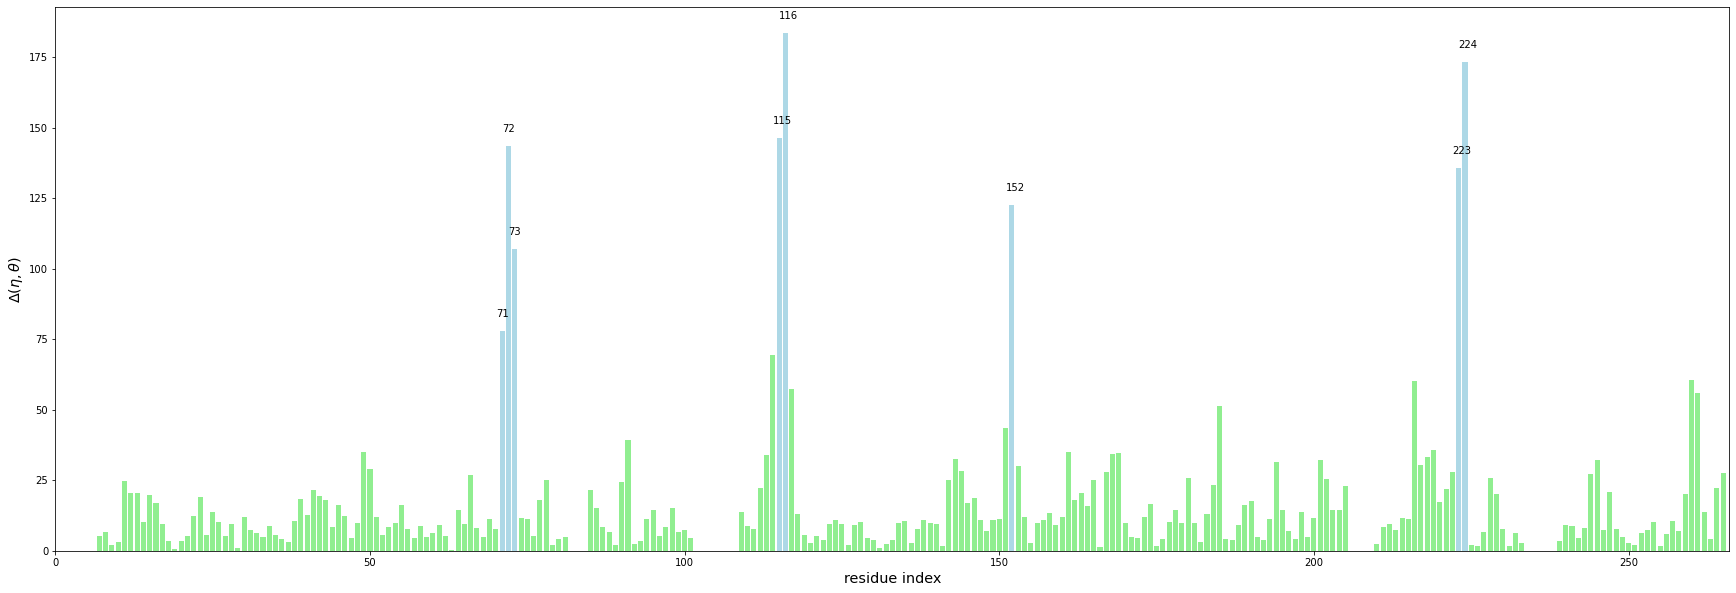

In [15]:
fig = plt.figure(figsize = (30, 10))
ax = fig.add_subplot(111)
for i in delta:
    if i < 266:
        if delta[i] > 70:
            plt.bar(i, delta[i], color = "lightblue", label = 'large')
            ax.annotate('%d' %i, xy = (i, delta[i]), xytext = (i-1, delta[i]+5) )
        else:
            plt.bar(i, delta[i], color = "lightgreen", label = "small")
    else:
        continue
# plt.legend(loc = 'upper right')
plt.xlabel('residue index', size = 'x-large')
plt.ylabel('$\Delta(\eta, \\theta )$', size = 'x-large')
plt.xlim([0,266])
plt.savefig('delta_plot.png', dpi = 100)